# **Homework 3:** Logistic regression and classification

### Collaborators

Please list anyone you discussed or collaborated on this assignment with below.

LIST COLLABORATORS HERE

### Course feedback

Please submit this week's course survey here: https://forms.gle/PC3AYmqanDChmqCDA

# Important notes

**This homework requires installing additional python libraries. You can install all the nessecary dependencies by running: `pip install -r requirements.txt` in the homework directory. If using Colab, this step should not be needed.**

In this homework, we will use the following convention for dimentionality:

$N:\quad\text{Number of observations in a dataset, so } \mathcal{D} = \{ (\mathbf{x}_1, y_1),\ (\mathbf{x}_2, y_2),\ ... \,(\mathbf{x}_N, y_N) \}$

$d:\quad\ \text{Dimension of input (number of features), so } \mathbf{x}_i \in \mathbb{R}^d$

$C: \quad\ \text{Number of classes, so } y_i \in \{1,...,C\}$

In [12]:
# Uncomment and run if using Colab!

#import urllib.request
#remote_url = 'https://gist.githubusercontent.com/gabehope/2f0c3af9eed3b910037df98e21c6c035/raw/925ff6b8ad5dcc2c17674b6ec609d854a811c453/hw2_code.py'
#with urllib.request.urlopen(remote_url) as remote, open('hw3_support.py', 'w') as local:
#  [local.write(str(line, encoding='utf-8')) for line in remote]

In [1]:
# Run me first!
import autograd.numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from hw3_support import get_dataset, gradient_descent, test_nll, test_nll_grad, test_predict, plot_boundary, test_softmax, test_split


# Background

In class we derived the logistic regression model for making predictions on binary data. Recall the the prediction function for logistic regression can be written as:

$$f(\mathbf{x}) = \mathbb{I}(\mathbf{x}^T\mathbf{w} \geq 0)$$

The estimated probability of $y=1$ as:
$$p(y=1\mid \mathbf{x}, \mathbf{w}) = \sigma(\mathbf{x}^T\mathbf{w})$$

Also recall that the negative log-likelihood loss for logistic regression can be written as:

$$\mathbf{NLL}(\mathbf{w}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \log \sigma\big((2 y_i - 1)\mathbf{x}_i^T\mathbf{w}\big)$$

and it's gradient with respect to $\mathbf{w}$ is:
$$\nabla_{\mathbf{w}}\mathbf{NLL}(\mathbf{w}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \big(1 - \sigma((2 y_i - 1)\mathbf{x}_i^T\mathbf{w})\big) \big(2 y_i - 1\big)\mathbf{x}_i$$


Below is an implementation of logistic regression using the functions we derived in class. In this example, we've created a logistic regression class that encapsulates the weights along with all of the functions we need to train and make predictions with the model.

In [2]:
def linear_function(X, w):
    # Returns a linear function of X (and adds bias)
    X = np.pad(X, ((0,0), (0,1)), constant_values=1.)
    return np.dot(X, w)

def sigmoid(x):
    # Computes the sigmoid function
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    def __init__(self, dims):
        '''
        Args:
            dims (int): d, the dimension of each input
        '''
        self.weights = np.zeros((dims + 1,))

    def predict(self, X):
        '''
        Predict labels given a set of inputs.

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            pred (int array): A length N array of predictions in {0, 1}
        '''
        return (linear_function(X, self.weights) > 0).astype(int)

    def predict_probability(self, X):
        '''
        Predict the probability of each class given a set of inputs

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            probs (array): A length N vector of predicted class probabilities
        '''
        return sigmoid(linear_function(X, self.weights))

    def accuracy(self, X, y):
        '''
        Compute the accuracy of the model's predictions on a dataset

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            acc (float): The accuracy of the classifier
        '''
        return np.mean(self.predict(X) == y)

    def nll(self, X, y):
        '''
        Compute the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (int array): A length N vector of labels.
        Returns:
            nll (float): The NLL loss
        '''
        xw = linear_function(X, self.weights)
        py = sigmoid((2 * y - 1) * xw)
        return -np.sum(np.log(py))

    def nll_gradient(self, X, y):
        '''
        Compute the gradient of the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            grad (array): A length (d + 1) vector with the gradient
        '''
        xw = linear_function(X, self.weights)
        py = sigmoid((2 * y - 1) * xw)
        grad = ((1 - py) * (2 * y - 1)).reshape((-1, 1)) * np.pad(X, [(0,0), (0,1)], constant_values=1.)
        return -np.sum(grad, axis=0)

    def nll_and_grad(self, X, y):
        '''
        Compute both the NLL and it's gradient

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            nll (float): The NLL loss
            grad (array): A length (d + 1) vector with the gradient
        '''
        return self.nll(X, y), self.nll_gradient(X, y)



Let's take a look at how to use this class. The code below uses the `scikit-learn` library to load a simple example dataset. Here we have 2 classes (purple and yellow) and our goal will be to separate the two.

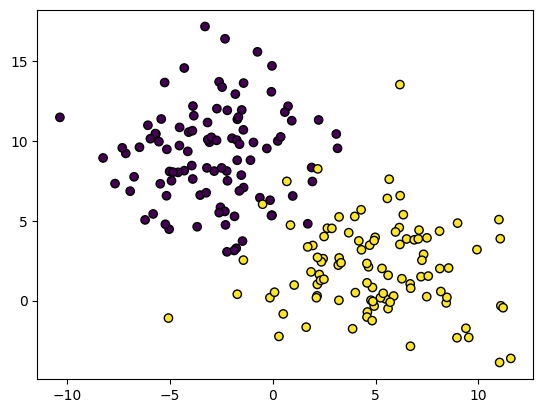

In [23]:
# Load a dataset with sklearn
X, y = make_blobs(n_samples=200, random_state=42, centers=2, cluster_std=3)

# Show a plot of the data
plt.scatter(X[:, 0], X[:, 1], c=y,  edgecolor="black");

We can create a model using the `LogisticRegression` class, specifying the number of features ($d$):

In [4]:
model = LogisticRegression(X.shape[1])

We can train the model using the `gradient_descent` function provided in the support code:

***Note:** Use this learning rate and number of steps throughout the homework!*

In [5]:
losses = gradient_descent(model, X, y, lr=1e-6, steps=2500, watch=False)

# Uncomment to run with a live visualization
# losses = gradient_descent(model, X, y, lr=1e-6, steps=500, image_shape=images[0].shape, watch=True)

Loss 137.26, accuracy: 0.89:   0%|          | 0/2500 [00:00<?, ?it/s]

Loss 42.77, accuracy: 0.95: 100%|██████████| 2500/2500 [00:01<00:00, 2373.00it/s]


We provide a built-in function to visualize the data and decision boundary

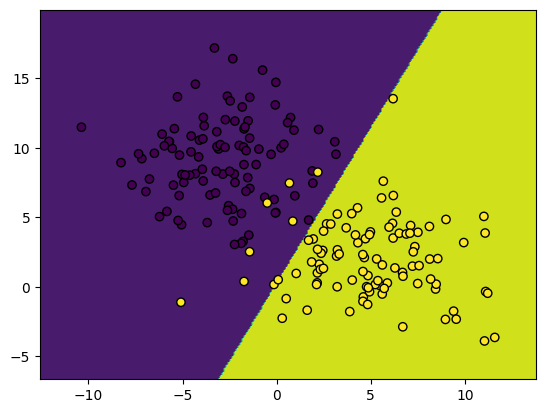

In [21]:
# Show an image and the corresponding prediction
plot_boundary(model, X, y)

We can also make predictions using the built-in methods. Here we'll visualize which observations we predicted incorrectly:

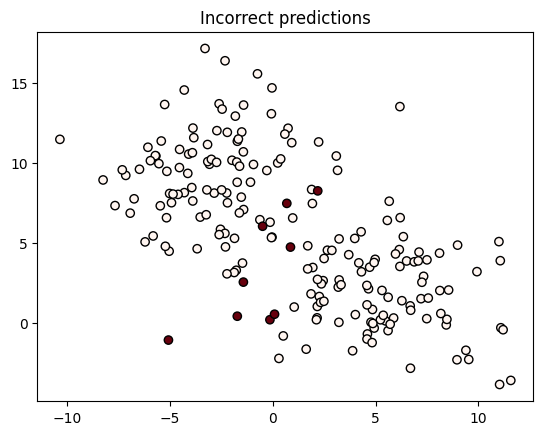

In [24]:
prediction = model.predict(X)
probabilities = model.predict_probability(X)

# Get the probability of the prediction [p(y=1) if prediction is 1 otherwise p(y=0)]
probability_of_prediction = np.where(prediction, probabilities, 1 - probabilities)
plt.scatter(X[:, 0], X[:, 1], c=(1 - prediction == y), edgecolor='black', cmap='Reds')
plt.title('Incorrect predictions');

# Part 1: Logistic regression

We'll first evaluate the performance of the logistic regression model above.

#### **Q1:** Train and test splits

Write a function to split the provided dataset into a *train set* and a *test set*. The train set should include 70% of the observations and the test set should include the remaining 30%. The data should be randomly shuffled to make sure there is no bias in the ordering.

In [ ]:
def split_data(X, y):
    ## YOUR CODE HERE

    return Xtrain, ytrain, Xtest, ytest

# Test the function
Xtrain, ytrain, Xtest, ytest = split_data(X, y)
test_split(X, y, Xtrain, ytrain, Xtest, ytest)

#### **Q2:** Model evaluation

Using the function you just wrote, train a new logistic regression model on just the training data. Evaluate the **accuracy** and **loss** of the trained model on *both* the **training data** and the **test data**.

In [ ]:
## YOUR CODE HERE



print('Training accuracy: %.3f, loss: %.3f' % (train_acc, train_loss))
print('Test accuracy: %.3f, loss: %.3f' % (test_acc, test_loss))

# Part 2: Alternative losses

Our original goal for classification was simply to maximize the number of correct classifications we'd make. Using accuracy as a loss function looked something like this:

$$\mathbf{Acc.}(\mathbf{w}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \mathbb{I}\big((2 y_i - 1)\mathbf{x}_i^T\mathbf{w} \geq 0 \big)$$

Which unfortunately wasn't differentiable and therefore we couldn't optimize it with gradient descent.

The maximum likelihood principal helped us derive a useful loss function for classification:

$$\mathbf{NLL}(\mathbf{w}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \log \sigma\big((2 y_i - 1)\mathbf{x}_i^T\mathbf{w}\big)$$


(and had the additional benefit of letting us estimate *probabilities*). But as we saw with linear regression that we're not limited to thinking about things from the probabilistic perspective. Now that we've seen what a reasonable loss function for classification looks like, we could try some variations with similar properties.


Let's consider the **exponential loss**:

$$\mathbf{ExpLoss}(\mathbf{w}, \mathbf{X}, \mathbf{y})=\sum_{i=1}^N \exp\big(-(2 y_i - 1)\mathbf{x}_i^T\mathbf{w}\big)$$

*Note that $\exp(x) = e^x$*

Plotting this we see that just like negative log-likelihood, the loss monotonically increases as we get further from a correct prediction, which is what we'd like!

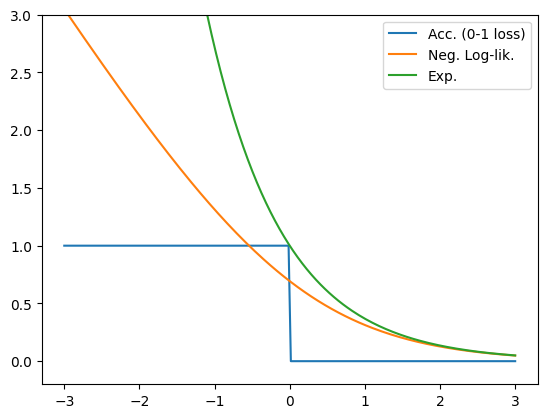

In [40]:
yxw = np.linspace(-3, 3, 200)
acc = np.where(yxw > 0, 0., 1.)
nll = -np.log(sigmoid(yxw))
exp = np.exp(-yxw)

plt.plot(yxw, acc, label='Acc. (0-1 loss)')
plt.plot(yxw, nll, label='Neg. Log-lik.')
plt.plot(yxw, exp, label='Exp.')
plt.ylim((-0.2, 3))
plt.legend();

#### **Q3:** Exponential loss gradient
Derive the gradient of the exponential loss with respect to $\mathbf{w}$, the weight vector for the linear model.


YOUR ANSWER HERE

$$\nabla_{\mathbf{w}} \textbf{ExpLoss}(\mathbf{W}, \mathbf{X}, \mathbf{y}) = $$

#### **Q4:** Exponential loss implementation

Let's try using the exponential loss. Below is a sub-class of the `LogisticRegression` class above that replaces the negative log-likelihood loss with the exponential loss.

Complete the `nll_gradient` method using the gradient you derived above.

In [ ]:
class ExponentialRegression(LogisticRegression):
  def nll(self, X, y):
        '''
        Compute the exponential loss.

        Args:
            X (array): An N x d matrix of observations.
            y (int array): A length N vector of labels.
        Returns:
            nll (float): The exponential loss
        '''
        xw = linear_function(X, self.weights)
        return -np.sum(np.exp(-xw))

  def nll_gradient(self, X, y):
      '''
      Compute the gradient of the exponential loss.

      Args:
          X (array): An N x d matrix of observations.
          y (array): A length N vector of labels.
      Returns:
          grad (array): A length (d + 1) vector with the gradient
      '''
      # YOUR CODE HERE


#### **Q5:** Exponential loss comparison

Repeat **q2**, training a new **exponential-loss** regression model on just the training data. Evaluate the **accuracy** and **loss** of the trained model on *both* the **training data** and the **test data**.

In [ ]:
## YOUR CODE HERE



print('Training accuracy: %.3f, loss: %.3f' % (train_acc, train_loss))
print('Test accuracy: %.3f, loss: %.3f' % (test_acc, test_loss))

What differences do you notice between this and the log-likelihood loss?

YOUR ANSWER HERE

#### **Q6:** Linear losses

Note that both the negative log-likelihood and exponential losses are strictly positive, and threrefore bounded below by 0. **Why is having a lower bound a desirable property for a classification loss?**

For instance, why not simply use a linear loss?

$$\mathbf{Loss}(\mathbf{w}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N (2 y_i - 1)\mathbf{x}_i^T\mathbf{w}$$

*Hint: If you're unsure, you could try modifying the `ExponentialRegression` class to use a linear loss and see what happens! Deriving the gradient should be even simpler than for the exponential loss.*

YOUR ANSWER HERE

# Part 3: Multinomial logistic regression

In this part, we will look at implementing **multinomial logistic regression**. Recall that this model extends logistic regression to the cases where there may be more than 2 possible labels, so $y\in\{1,...,C\}$, where $C$ is the number of *classes* (possible outputs).

We saw that rather than having a single weight vector, this model has a weight vector for *each class*, $\mathbf{w}_1,...,\mathbf{w}_C$. We can view these together as the *rows* of a weight matrix $\mathbf{W}$:
$$\mathbf{W} = \begin{bmatrix} \mathbf{w}_1^T \\ \mathbf{w}_2^T \\ \vdots \\ \mathbf{w}_C^T \end{bmatrix}$$

We saw that the prediction function for this model was:
$$f(\mathbf{x}) = \underset{c\in \{1,...,C\}}{\text{argmax}}\ \mathbf{x}^T\mathbf{w}_c$$

The probabilistic model was defined as:
$$
p(y_i=c \mid \mathbf{x}, \mathbf{W}) = \text{softmax}(\mathbf{x}^T\mathbf{W})_c=\frac{e^{\mathbf{x}^T\mathbf{w}_c}}{\sum_{j=1}^Ce^{\mathbf{x}^T\mathbf{w}_j}}
$$

The negative log-likelihood loss was defined as:
$$
\textbf{NLL}(\mathbf{W}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \bigg(\mathbf{x}_i^T\mathbf{w}_{y_i}- \log\sum_{j=1}^Ce^{\mathbf{x}_i^T\mathbf{w}_{j}}\bigg)
$$

In the next few questions we will create a *modified* version of our logistic regression class that supports multinomal logistic regression. The class definition is below. A few things to note:

**1:** We will still assume `y` is an array of `int` in numpy. We can convert an array `y` to an array of `int` with `y = y.astype(int)` and back with `y = y.astype(float)`

**2:** Remeber that numpy is **0-indexed**, so our classes will actually be $0$ to $C-1$, ($y\in \{0,...,C-1\}$)

**2:** We will assume our weight matrix is a $C \times d$ matrix as shown below

In [ ]:
class MultinomialLogisticRegression(LogisticRegression):
    def __init__(self, classes, dims):
        '''
        Args:
            classes (int): C, the number of possible outputs
            dims (int): d, the dimension of each input
        '''
        self.classes = classes
        self.weights = np.zeros((classes, dims + 1,))

#### **Q7:** Prediction

Write a function to make a prediction using the multinomial logistic regression prediction rule above. (assume `self` is the `MultinomialLogisticRegression` object)

In [ ]:
def multiclass_predict(self, X):
    '''
    Predict labels given a set of inputs.

    Args:
        X (array): An N x d matrix of observations.
    Returns:
        pred (int array): A length N array of predictions in {0,...,(C-1)}
    '''
    W = self.weights

    ## YOUR CODE HERE
    pred =

    return pred

## Test the function
test_predict(multiclass_predict)

## Add it to our class
MultinomialLogisticRegression.predict = multiclass_predict

#### **Q8:** Softmax

Implement the softmax function.
$$
\text{softmax}(\mathbf{x})_c = \frac{e^{x_c}}{\sum_{j=1}^Ce^{x_j}}, \quad
\text{softmax}(\mathbf{x}) = \begin{bmatrix}\frac{e^{x_1}}{\sum_{j=1}^Ce^{x_j}} \\ \frac{e^{x_2}}{\sum_{j=1}^Ce^{x_j}} \\ \vdots \\ \frac{e^{x_C}}{\sum_{j=1}^Ce^{x_j}} \end{bmatrix}
$$

You function should accept inputs as either a length $C$ vector or as an $N\times C$ matrix. If the input is a matrix, the softmax function should be applied to each **row** of the matrix.

In [ ]:
def softmax(x):
    '''
    Apply the softmax function to a vector or matrix

    Args:
        X (array): An N x C matrix of transformed inputs (or a length C vector)
    Returns:
        probs (array):  An N x C matrix with the softmax function applied to each row
    '''
    ## YOUR CODE HERE


test_softmax(softmax)

#### **Q9:** Multinomial logistic regression NLL

Implement a function to compute the multinomial logistic regression negative log-likelihood.
$$
\textbf{NLL}(\mathbf{W}, \mathbf{X}, \mathbf{y})=-\sum_{i=1}^N \bigg(\mathbf{x}_i^T\mathbf{w}_{y_i}- \log\sum_{j=1}^Ce^{\mathbf{x}_i^T\mathbf{w}_{j}}\bigg)
$$

***Hint:** Recall that $y_i$ is an integer, so $\mathbf{w}_{j}$ refers to the row of the weight matrix at index $y_i$ (you could access this as `W[y[i]]`). It's possible to answer this question without loops, but you may find it easier to loop over each possible class/observation.*



In [ ]:
def nll(self, X, y):
    '''
    Compute the negative log-likelihood loss.

    Args:
        X (array): An N x d matrix of observations.
        y (int array): A length N vector of labels.
    Returns:
        nll (float): The NLL loss
    '''
    W = self.weights
    ## YOUR CODE HERE

    return nll

test_nll(nll)
MultinomialLogisticRegression.nll = nll

#### **Q10:** Gradient of NLL

Derive the gradient of the negative log-likelihood with respect to $\mathbf{w}_c$, the weight vector for a **single class**.

***Hint:** Again note that $\mathbf{w}_{y_i}$ refers to the weight vector corresponding to the **true** class of observation $i$, and so only depends on $\mathbf{w}_c$ if $y_i=c$. This means that:*
$$\frac{d}{d\mathbf{w}_c} \mathbf{x_i}^T \mathbf{w}_{y_i} = \begin{cases}\mathbf{x}_i \quad \text{ if } y_i = c \\ 0 \quad \ \text{ otherwise}  \end{cases}$$
*We can write this more compactly using an indicator function:*
$$\frac{d}{d\mathbf{w}_c} \mathbf{x_i}^T \mathbf{w}_{y_i} = \mathbb{I}(y_i=c)\ \mathbf{x}_i $$

YOUR ANSWER HERE

$$\nabla_{\mathbf{w}_c} \textbf{NLL}(\mathbf{W}, \mathbf{X}, \mathbf{y}) = $$

#### **Q11:** Implementing the gradient

Write a function that computes the gradient of the negative log-likelihood with repect to the weight vector for a given class, using the results of the derivation above.

In [ ]:
def nll_gradient_c(W, X, y, c):
    '''
    Compute the negative log-likelihood loss.

    Args:
        W (array): The C x d weight matrix.
        X (array): An N x d matrix of observations.
        y (int array): A length N vector of labels.
        c (int): The class to compute the gradient for
    Returns:
        grad (array): A length d vector representing the gradient with respect to w_c
    '''
    ## YOUR CODE HERE

    return grad



#### **Q12:** Implementing the full gradient

Using the function you just wrote, write a function to compute the full gradient with respect to the $C \times d$ weight matrix.
***Hint:** The output should be a matrix!*

In [ ]:
def nll_gradient(self, X, y, c):
    '''
    Compute the negative log-likelihood loss.

    Args:
        X (array): An N x d matrix of observations.
        y (int array): A length N vector of labels.
    Returns:
        grad (array): A C x d matrix representing the gradient with respect to W
    '''
    ## YOUR CODE HERE
    W = self.weights

    return grad

test_nll_grad(nll_gradient)
MultinomialLogisticRegression.nll_gradient = nll_gradient

Note if you are struggling with this problem, you can uncomment the following cell to get a valid gradient function based on your nll function. You can use this for testing to to complete the remaining questions.

In [ ]:
'''
def autograd_nll_gradient(self, X, y):
    import autograd
    def autograd_nll(W):
        temp_model = MultinomialLogisticRegression(self.classes, X.shape[1])
        temp_model.weights = W
        return temp_model.nll(X, y)
    return autograd.grad(autograd_nll)(self.weights)
MultinomialLogisticRegression.nll_gradient = autograd_nll_gradient
'''

Finally, we will test out our multinomial logistic regression classifier on the MNIST dataset (https://en.wikipedia.org/wiki/MNIST_database), one of the most popular datasets in machine learning!

We'll start by loading it as before. As we saw in class, before we can use logistic regression on image data, we first need to reshape it from a 3-dimensional array into a 2-dimensional matrix.

In [ ]:
images, labels, label_names = get_dataset('mnist')

image_shape = images[0].shape                # Keep track of the original image shape
X = images.reshape((images.shape[0], -1))    # Reshape into an N x d matrix X
y = labels
print('Image shape: ', images.shape, ', X shape: ', X.shape)

# Create the initial model
model = MultinomialLogisticRegression(classes=len(label_names), dims=X.shape[1])

#### **Q13:** Repeat question 2 using the MNIST dataset

In [ ]:
## YOUR CODE HERE



print('Training accuracy: %.3f, loss: %.3f' % (train_acc, train_loss))
print('Test accuracy: %.3f, loss: %.3f' % (test_acc, test_loss))

Here we'll show an image and the corresponding prediction made by the model.

In [ ]:
prediction = model.predict(X)
probabilities = model.predict_probability(X)

# Get the probability of the prediction [p(y=1) if prediction is 1 otherwise p(y=0)]
probability_of_prediction = np.where(prediction, probabilities, 1 - probabilities)

# Show an image and the corresponding prediction
plt.imshow(X[0].reshape(image_shape), cmap='gray')
print('Prediction: %s, probability: %.3f' % (label_names[prediction[0]], probability_of_prediction[0]))

#### **Q14:** Visualize the learned weights

The Matplotlib function `plt.imshow` (or `ax.imshow` for subplots) will display a matrix as an image as shown above.

Reshape the weight vector for **each of the 10 classes** in your trained model into a $28 \times 28$ matrix (ignore the last, bias dimension for each). Then plot each weight vector using the `imshow` function.

***Hint:** Your weight matrix should be of size $10 \times 785$*

In [ ]:
## YOUR CODE HERE